## EDA


In [ ]:
import pyarrow.parquet as pq

file_path = r"C:\Users\maian\OneDrive - The University of the West Indies, St. Augustine\Desktop\New folder\raw_files\cleaned_parquet\Handmade_Products_merged.parquet"

table = pq.read_table(file_path, columns=None, use_threads=True)
df_preview = table.to_pandas().head(5)

df_preview

,user_id,asin,parent_asin,rating,text,verified_purchase,helpful_vote,review_length,year,brand,main_category,title,average_rating,rating_number,price,category
0,AEN4YRPCW3NTRNQLWB5SJMYNULMQ,B07NLFM6NL,B07NLFM6NL,5.0,I love this print. My husband works for a fram...,True,0,32,51457,Unknown,Handmade,Mary Poppins - Everything Is Possible Quote - ...,4.8,103,9.99,Handmade_Products
1,AEN53UATEOEP2HDXG75JE4SFZB4A,B08B8X64NC,B08B8X64NC,5.0,These cotton masks were very made of durable m...,True,0,16,52543,Unknown,Handmade,4 Cotton Face Masks/Set- Washable Reusable- Ki...,4.3,27,None,Handmade_Products
2,AEN57AKDPJGIB73BPQNINE5KMHRA,B0B7285V2K,B0B7254VPX,5.0,it is so simple and natural looking!I LOVE IT ...,True,0,19,55077,Unknown,Handmade,"SoulKu Celestial Necklace, Healing Crystal Nec...",4.8,21,28.0,Handmade_Products
3,AEN57HAHQP6HCLDIRMANQVI4NZJA,B08LTM6VJB,B08LTM6VJB,5.0,Very well-made but for a small face of an adul...,True,0,17,52980,Unknown,Handmade,Handmade Custom Made Cotton Face Mask with Fil...,5.0,5,None,Handmade_Products
4,AEN5BD22Z2EKR5CKW3DTWAR6INKQ,B01ENZLEPM,B01ENZLEPM,4.0,Inconvenient to turn on.,True,0,4,51804,Unknown,Handmade,Farm theme Mason Jar LED Night Light with Gree...,3.5,13,None,Handmade_Products


Reading Grocery_and_Gourmet_Food_merged.parquet
Reading Handmade_Products_merged.parquet
Reading Health_and_Household_merged.parquet
Reading Health_and_Personal_Care_merged.parquet
Reading Home_and_Kitchen_merged.parquet
Reading Industrial_and_Scientific_merged.parquet
Reading Kindle_Store_merged.parquet
Reading Magazine_Subscriptions_merged.parquet
Reading Movies_and_TV_merged.parquet
Reading Musical_Instruments_merged.parquet


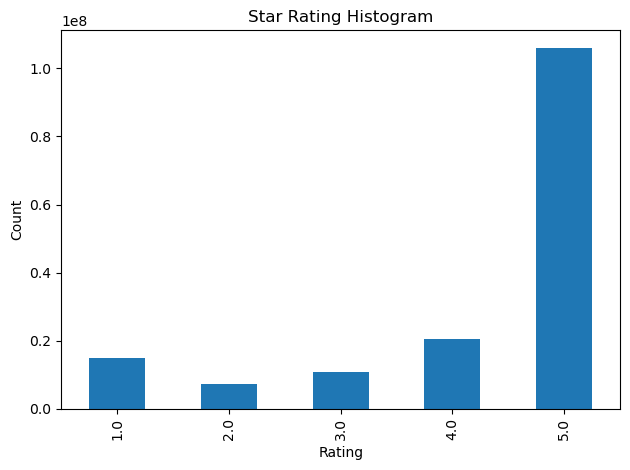

In [9]:
import pyarrow.parquet as pq
import pandas as pd
import glob
import os
from collections import Counter
import matplotlib.pyplot as plt

# Path to cleaned files
CLEANED_DIR = r"C:\Users\maian\OneDrive - The University of the West Indies, St. Augustine\Desktop\New folder\raw_files\cleaned_parquet"
all_files = glob.glob(os.path.join(CLEANED_DIR, "*_merged.parquet"))

# Count ratings
rating_counter = Counter()

for file in all_files:
    print(f"Reading {os.path.basename(file)}")
    pq_file = pq.ParquetFile(file)
    for batch in pq_file.iter_batches(batch_size=100_000):
        df = batch.to_pandas()
        if 'rating' in df.columns:
            rating_counter.update(df['rating'].value_counts().to_dict())

#Convert index to numeric and drop NaNs
rating_series = pd.Series(rating_counter)
rating_series.index = pd.to_numeric(rating_series.index, errors='coerce')
rating_series = rating_series.dropna().sort_index()

if rating_series.empty:
    print("⚠️ No valid rating data to plot.")
else:
    rating_series.plot(kind='bar', title='Star Rating Histogram')
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()


In [ ]:
import numpy as np

lengths = []

for file in all_files:
    print(f"Analyzing review lengths in {os.path.basename(file)}")
    pq_file = pq.ParquetFile(file)
    for batch in pq_file.iter_batches(batch_size=100_000):
        df = batch.to_pandas()
        if 'text' in df.columns:
            lengths.extend(df['text'].dropna().str.len().tolist())

# Plot Histogram
plt.hist(lengths, bins=np.linspace(0, 1000, 50), edgecolor='black')
plt.title("Review Length Distribution")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


In [ ]:
brand_counter = Counter()

for file in all_files:
    print(f"Counting brands in {os.path.basename(file)}")
    pq_file = pq.ParquetFile(file)
    for batch in pq_file.iter_batches(batch_size=100_000):
        df = batch.to_pandas()
        if 'brand' in df.columns:
            brand_counter.update(df['brand'].dropna().value_counts().to_dict())

# Top 10 brands
top_brands = pd.Series(brand_counter).sort_values(ascending=False).head(10)
top_brands.plot(kind='barh', title='Top 10 Brands')
plt.xlabel('Count')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
from datetime import datetime
from collections import defaultdict

year_rating_sum = defaultdict(float)
year_rating_count = defaultdict(int)

for file in all_files:
    print(f"Analyzing ratings over time in {os.path.basename(file)}")
    pq_file = pq.ParquetFile(file)
    for batch in pq_file.iter_batches(batch_size=100_000):
        df = batch.to_pandas()
        if 'timestamp' in df.columns and 'rating' in df.columns:
            # Drop NA values to prevent errors
            df = df[['timestamp', 'rating']].dropna()
            df['year'] = df['timestamp'].apply(lambda ts: datetime.utcfromtimestamp(ts).year)
            for year, group in df.groupby('year'):
                year_rating_sum[year] += group['rating'].sum()
                year_rating_count[year] += len(group)

# Compute averages
avg_ratings_by_year = {
    year: year_rating_sum[year] / year_rating_count[year]
    for year in year_rating_sum
}

# Plot
year_series = pd.Series(avg_ratings_by_year).sort_index()
year_series.plot(kind='line', marker='o', title='Average Star Rating Per Year')
plt.xlabel("Year")
plt.ylabel("Average Rating")
plt.grid(True)
plt.tight_layout()
plt.show()


ValueError: Length mismatch: Expected axis has 0 elements, new values have 1 elements